# Import relevant libraries

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup path

In [3]:
# set up paths
base_path = '../datasets'
cleaned_data_path = os.path.join(base_path, 'cleaned_data')

# Load data

In [4]:
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

# Analysis

**Thesis Statement:**

Workflow:
1) Step1  
2) Step2  
3) Step3  

**To do**
- There seems to be a trend on age-price so we dev scaling factor (average price by age with base age) to diminish the effect of age on price.
- Identify the effect of homophily (Membership closure) on performance -> performance metric = f(price, scaling_factor) and maybe combination of other metrics
- Identify the behavior of the transfer if it's related to our analysis,   
  - if yes: the analysis might be the cause  
  - if no: give some recommendation

## Fee-Age Analysis

In [186]:
fee_age = perf_eval_df[perf_eval_df['transfer_movement'] == 'in'][['age', 'fee_cleaned']]
fee_age

,age,fee_cleaned
1,21.0,0.203
3,24.0,4.280
4,25.0,1.350
7,27.0,1.350
9,28.0,2.700
...,...,...
16093,30.0,3.600
16095,26.0,4.730
16097,28.0,4.050
16098,28.0,1.800


<AxesSubplot:xlabel='age', ylabel='fee_cleaned'>

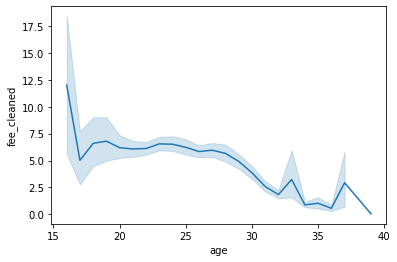

In [18]:
sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned')

In [169]:
# descriptive statistics
desc_stat = fee_age.groupby('age')['fee_cleaned'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
# remove group with small number of observations
desc_stat = desc_stat[desc_stat['count'] > 30]

In [170]:
# There are some outliers that greatly influence the mean and thus using median is more robust
desc_stat

,mean,median,std,min,max,count
age,,,,,,
18.0,6.597215,3.150,9.052794,0.045,36.00,65
19.0,6.805434,2.790,14.677397,0.045,130.50,196
20.0,6.194580,3.565,9.746957,0.023,124.20,348
21.0,6.078661,2.700,8.813119,0.009,72.00,572
22.0,6.121019,3.150,8.364714,0.010,67.50,724
23.0,6.550291,3.150,9.885303,0.019,94.50,877
24.0,6.519200,3.240,9.621015,0.054,90.90,857
25.0,6.227898,2.970,11.156452,0.015,199.80,854
26.0,5.837947,3.150,8.363540,0.045,78.30,830


In [171]:
# downtrend is observed from the age of 29
pd.DataFrame(desc_stat['median'].pct_change()).fillna(0).style.background_gradient(cmap='coolwarm')

,median
age,
18.0,0.000000
19.0,-0.114286
20.0,0.277778
21.0,-0.242637
22.0,0.166667
23.0,0.000000
24.0,0.028571
25.0,-0.083333
26.0,0.060606


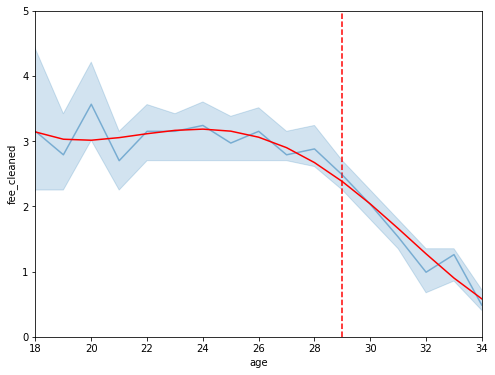

In [176]:
# visualize
fig, ax = plt.subplots(figsize = (8, 6))

sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.median, alpha = 0.5)

xlim = (desc_stat.index[0], desc_stat.index[-1])
ylim = (0, 5)

# add vertical line
plt.vlines(x = 29, ymin = ylim[0], ymax = ylim[1],
           colors = 'red', linestyles = 'dashed')

# fit polynomial to smoothen the trend (for adjustment coefficient)
x = list(desc_stat['median'].index)
y = list(desc_stat['median'])

fit = np.polyfit(x, y, deg = 4)
poly1d = np.poly1d(fit)

# add adjustment line
plt.plot(x, poly1d(x), '-', c = 'red')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [212]:
# develop adjustment coefficient
fitted_value = poly1d(x)

baseline = fitted_value[0]
base_value = np.divide(fitted_value, baseline)
coef = np.reciprocal(base_value)

temp_df = pd.DataFrame(data = {'age': desc_stat['median'].index, 
                               'coef': coef})
temp_df

,age,coef
0,18.0,1.000000
1,19.0,1.036708
2,20.0,1.041973
3,21.0,1.028369
4,22.0,1.008515
5,23.0,0.992200
6,24.0,0.986311
7,25.0,0.996012
8,26.0,1.026201
9,27.0,1.083025


In [213]:
# extend age range to cover the data using lower-upper bound coefficient
age_df = pd.DataFrame(data = {'age': sorted(fee_age['age'].unique())})
adj_coef_table = pd.merge(age_df, temp_df, on = 'age', how = 'left')
adj_coef_table['coef'] = adj_coef_table['coef'].interpolate(method = 'linear', limit_direction = 'both')
adj_coef_table

,age,coef
0,16.0,1.000000
1,17.0,1.000000
2,18.0,1.000000
3,19.0,1.036708
4,20.0,1.041973
5,21.0,1.028369
6,22.0,1.008515
7,23.0,0.992200
8,24.0,0.986311
9,25.0,0.996012


## Homophily-Performance Analysis